**This is the main notebook.**

It puts together all other functions to encode the SimLex-999 concepts and its semantic features into high-dimensional binary vectors. These vectors are then used to estimate the semantic similarity between each pair in SimLex-999.
This notebook also measure the correlation between the similarity estimated by SimLex participants and our model. 

## Libraries

In [14]:
import requests
import csv
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats.stats import spearmanr
import pickle
import time
import os
import random

# Vital function for pairwise distances...
from scipy.spatial.distance import pdist

# For Dendrogram..
from scipy.cluster.hierarchy import linkage, dendrogram

# Clustering based on cophenetic distance
from scipy.cluster.hierarchy import fcluster

## 1. Reading SimLex-999

In [15]:
%run ConceptNet_VSA_AuxFunctions.ipynb  #To use reading functions

# Getting list of concepts
Pairs, Concepts = Read_SimLex()
Pairs.sort(key= lambda x: x[2])


# Getting partitions
Groups = CreatingPartitions()

# Getting list of pairs
GPairs = Pairs_per_Partition()

# Getting semantic features file
Feat_matrix = Reading_Feature_Matrix()
Feat_matrix[0][0]

There are 751 concepts
There are 137 partitions


['bed', 'RelatedTo', 'sleeping', ['sleep'], 14.61204982, 5.0]

#### Converting Feat_matrix to dictionary

Access information efficiently

In [16]:
def Feat_dict_fun():
    Feat_dict = {}
    for con in Feat_matrix:
        # Concept name is main key...
        Feat_dict[con[0][0]] = {}
        # feat_names in definition
        feat_names = list(set([x[1] for x in con]))
        # Dictionary for a single feat name of con
        #Dict_feat_name = {}
        for feat_nm in feat_names:
            Feat_dict[con[0][0]][feat_nm] =  [x[2:] for x in con if x[1] == feat_nm]
    return Feat_dict

Feat_dict = Feat_dict_fun()

## 2. Estimating similarity of SimLex-999 pairs 

It uses all previos functions to encode concepts and its semantic features into high-dimensional vectors. 
It clusters similar features and assigns them closer (rather than orthogonal) vectors. 
It also computes Spearman's correlation between the similarity values of our model with SimLex-999 scores. 

### 2.1 Parameters

In [45]:
Feat_matrix

[[['bed', 'RelatedTo', 'sleeping', ['sleep'], 14.61204982, 5.0],
  ['bed', 'IsA', 'bed', ['bed'], 14.61204982, 5.0],
  ['bed', 'RelatedTo', 'bed', ['bed'], 14.61204982, 5.0],
  ['bed', 'RelatedTo', 'furniture', ['furniture'], 10.91311138, 5.0],
  ['bed', 'UsedFor', 'have_sex', ['have', 'sex'], 9.38083152, 5.0],
  ['bed', 'RelatedTo', 'mattress', ['mattress'], 8.723989913, 5.0],
  ['bed', 'RelatedTo', 'place', ['place'], 8.361817984, 5.0],
  ['bed', 'RelatedTo', 'pillows', ['pillow'], 6.052437525, 5.0],
  ['bed', 'RelatedTo', 'sleeping_place', ['sleep', 'place'], 5.360596982, 5.0],
  ['bed', 'RelatedTo', 'sheets', ['sheet'], 5.276362383, 5.0],
  ['bed',
   'RelatedTo',
   'sleeping_furniture',
   ['sleep', 'furniture'],
   5.270294109,
   5.0],
  ['bed', 'RelatedTo', 'cot', ['cot'], 4.915689168, 5.0],
  ['bed', 'RelatedTo', 'pillow', ['pillow'], 4.593909011, 5.0],
  ['bed', 'IsA', 'place', ['place'], 4.472135955, 5.0],
  ['bed', 'UsedFor', 'resting_on', ['rest'], 4.472135955, 5.0],
  ['

In [17]:
%run EncodingDataset.ipynb

# General parameters:
max_d = 0.7      # Threshold distance for clustering features
diff_bits = 4600  # This is the Hamming distance between similar enought features. Unrelated features are approximately 
                  # 5,000 bits away
    
min_w = 2      # Minimum weight for a feature to be consider relevant  
min_feat = 3   # Minimum number of features a concept might have

# Initializing memory of HD vectors
Init_mem(Concepts, Feat_matrix, 2) 

Begining to encode dataset...
End of encoding


### 2.2 Main Loop

In [18]:
for i_g in range(len(Groups)):     #Loops over partitions
    Grupo = Groups[i_g]  # -> Concepts in partition i_g
    PGrupo = GPairs[i_g] # -> Pais in partition i_g
    GRelatedness = [x[2] for x in PGrupo]

    # List of files containing features for partition i_g 
    list_files_features = os.listdir('../Data/ClusteringData/03 Features_Group/')
    features_files_group_i = [f for f in list_files_features if '_' + str(i_g) +'_' in f]

    # List of files containing pairwise distance for partition i_g
    list_files_X = os.listdir('../Data/ClusteringData/04 PairwiseDistance/')
    X_mat_files_group_i = [f for f in list_files_X if '_' + str(i_g) +'_' in f]

    # Sanity check...
    assert len(features_files_group_i) == len(X_mat_files_group_i)

    # Extracting list of relations from filenames
    Relations = map(extrac_relation_name, features_files_group_i)

    # Dictionary of features and distances 
    Dict_Features_Grupo_i = {}
    Dict_Distances_Grupo_i = {}

    for i in range(len(X_mat_files_group_i)):
        name_relation = extrac_relation_name(X_mat_files_group_i[i])
        Dict_Features_Grupo_i[name_relation] = np.load('../Data/ClusteringData/03 Features_Group/' + features_files_group_i[i])
        Dict_Distances_Grupo_i[name_relation] = np.load('../Data/ClusteringData/04 PairwiseDistance/' + X_mat_files_group_i[i])
    
    # Looping over each realtion
    for rela in Relations:
        # Linkage
        distance = linkage(Dict_Distances_Grupo_i[rela], 'average')
        # Cluster por umbral de distancia
        clusters = fcluster(distance, max_d, criterion='distance')
        # Clustering features
        uniques = np.unique(clusters)
        Features = Dict_Features_Grupo_i[rela]
        Clusters = []
        for i in uniques:
            Clusters.append([Features[j][0] for j in range(len(clusters)) if clusters[j] == i])
    
        # Modifying ID_vectors
        for cluster in Clusters:
            # Only clusters with more than 1 elements
            if len(cluster) > 1:
                # Modifying labels of features according to cluster...
                change_dict_defs(Grupo, rela, cluster, i_g)
                # 1) Takes one element of cluster (centroid)
                seed = cluster[0]
                # 2) Modifying string 'feat_name'
                seed = seed + '_' + rela[:5] + rela[-2:] + "_g" + str(i_g)
                # 3) Creating a new seed
                seed_vec = SparseBitString(N)
                HDvector(seed_vec, seed)
                # 4) Loop to assign new vectors (non-orthogonal) 
                for word in cluster[1:]:
                    HDvector(contamina_vec(seed_vec, diff_bits), word + '_' + rela[:5] + rela[-2:] + "_g" + str(i_g))

    # Creating new semantic pointers for current partition
    for conc in Grupo:
        vec_ID = Dict[conc]
        vec_ID.setPointer(CreateSemanticPointer(Dict_defs[conc])) 

#### Example of the last dendrogram done in loop

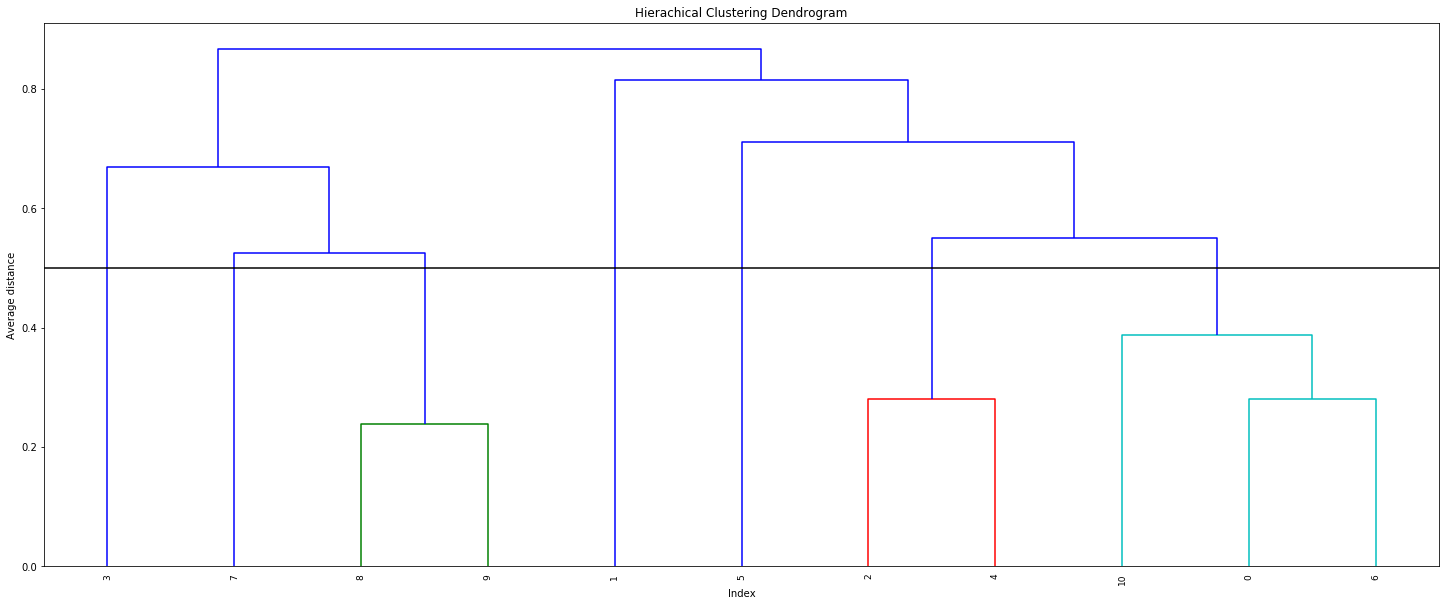

In [19]:
# Plotting dendrogram
plt.figure(figsize=(25,10))
plt.title("Hierachical Clustering Dendrogram")
plt.xlabel("Index")
plt.ylabel("Average distance")
dn = dendrogram(distance,
           leaf_rotation=90.,
           leaf_font_size=9.,
           color_threshold = .5);
plt.axhline(.5, c='k');

### 2.3 Filter

In this cell some features are filtered out. We try to find the most important semantic features. 

In [20]:
def intersection(lst1, lst2): 
    "Finds intersection between 2 lists"
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3

# Filter Loop
for concept in Concepts:
    # Step 1. Get pairs...
    pairs_con = get_Pairs(concept)

    # Iterating over pairs...
    Intersec_delete = []
    for pairr in pairs_con:
        # Step 3. Comparing distance between feat_values with equal feat_name...
        if pairr[0] == concept:
            i_c = 0; i_oth = 1
        else:
            i_c = 1; i_oth = 0

        Delete_list = []
        for feature in Dict_defs[pairr[i_c]]:
            # Features of the other concept... with same feature_name as feature...
            feats_con2 = get_feat_values(Dict_defs[pairr[i_oth]], feature[0])
            # Measuring distance between feature[1] and feature_values from other concept...
            distann = map(lambda x: Dict[feature[1]].dist(Dict[x]), feats_con2)
            if len(distann) == 0 or min(distann) > 4000:
                Delete_list.append(feature)
        Intersec_delete.append(Delete_list)

    to_delete_features = reduce(intersection, Intersec_delete)

    # This loops delete features with smaller weights
    new_to_delete_features = []
    for to_del in to_delete_features:
        for val in Feat_dict[concept][to_del[0]]:
            # Checking weight 
            if val[0] == delete_relation_code(to_del[1]) and  val[2] <= min_w:  # Use auxiliar function (delete _isaisa_gX) 
                    new_to_delete_features.append(to_del)
    
    # Deleting features from the actual Definition Dictionary 
    if len(Dict_defs[concept]) - len(new_to_delete_features) >= min_feat:
        Dict_defs[concept] = [x for x in Dict_defs[concept] if x not in new_to_delete_features]
        # Creating new semantic pointer
        Dict[concept].setPointer(CreateSemanticPointer(Dict_defs[concept]))
    elif len(Dict_defs[concept]) >= min_feat:
        sample_to_delete = random.sample(new_to_delete_features, len(Dict_defs[concept]) - min_feat)
        Dict_defs[concept] = [x for x in Dict_defs[concept] if x not in sample_to_delete]
        # Creating new semantic pointer
        Dict[concept].setPointer(CreateSemanticPointer(Dict_defs[concept]))

### 2.4 Measuring semantic similarity 

Minimum: 1383.0 Maximum: 5120.0

Spearman correlation coefficient:  0.6128879042585484

Error cuadratico medio: 7.3414506594784115


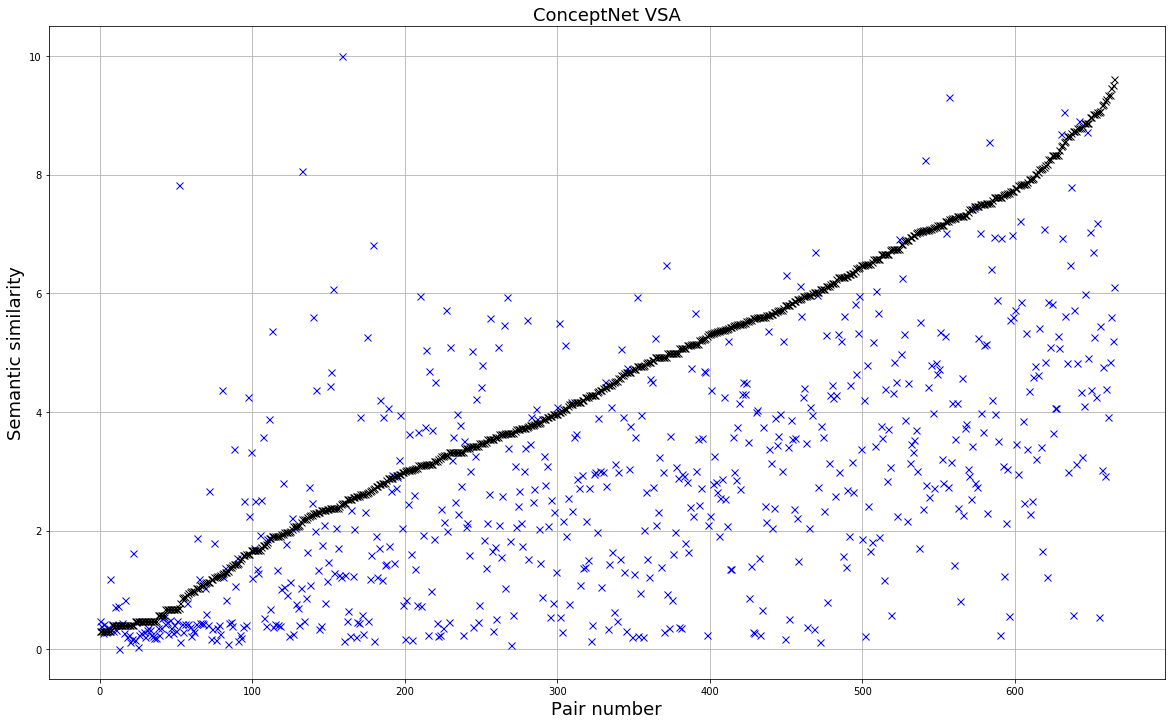

In [21]:
# List storing similarity values
HD_sim = []

for p in Pairs: #Pairs
    HD_sim.append(HDvector.dist(Dict[p[0]].getPointer(), Dict[p[1]].getPointer()))

# Max-min normalization of HD_sim... aunque no lo use
max_sim = float(max(HD_sim))
min_sim = float(min(HD_sim))

print "Minimum:", min_sim, "Maximum:", max_sim

HD_sim = map(lambda x: (1. - (float(x) - min_sim) / (max_sim - min_sim)) * 10, HD_sim)

# Plotting
plt.rcParams["figure.figsize"] = [20,12]
f_size = 18
plt.plot(HD_sim, color='b', linestyle='None', marker='x', markersize=7, linewidth=1 )  
plt.title('ConceptNet VSA', fontsize=f_size)
plt.xlabel('Pair number', fontsize=f_size)
plt.ylabel('Semantic similarity', fontsize=f_size)
plt.grid(True)

plt.plot([x[2] for x in Pairs], color='k', linestyle='None', marker='x', markersize=7, linewidth=1 ) 

# Correlation
print "\nSpearman correlation coefficient: ", spearmanr(HD_sim, [x[2] for x in Pairs])[0]

# Mean square error
from sklearn.metrics import mean_squared_error
print "\nError cuadratico medio:", mean_squared_error(HD_sim, [x[2] for x in Pairs])

#### Exporting dictionaries (for Demo)

In [39]:
f = open("Dict.pkl","wb")
pickle.dump(Dict,f)
f.close()

f = open("Dict_defs.pkl","wb")
pickle.dump(Dict_defs,f)
f.close()

### 2.5 Interpretability

We take a pair of concepts, and analyze its semantic features

In [22]:
pp = ['agony', 'grief'] #['rail', 'fence'] #
print "Pareja:", pp, "\n"
cuenta = 0
rep_feat = []
for f in Dict_defs[pp[0]]:
    if f in Dict_defs[pp[1]]:
        cuenta += 1
        rep_feat.append(f)
        
print "cuenta:",cuenta
print "features:", sorted(rep_feat)

# word 1
print "\nword1:", pp[0]
for p in sorted(Dict_defs[pp[0]]):
    print p

# word 2
print "\nword2:", pp[1]
for p in sorted(Dict_defs[pp[1]]):
    print p

Pareja: ['agony', 'grief'] 

cuenta: 0
features: []

word1: agony
['IsA', 'suffering']
['RelatedTo', 'agonize']
['RelatedTo', 'agony']

word2: grief
['IsA', 'feeling_depressed']
['IsA', 'sorrow']
['RelatedTo', 'harass']


## 3. Comparing results with Numberbatch.

In [23]:
A = pd.read_hdf('../Code/mini.h5')
            
def numberbatch_dist (w1, w2):
    #print w1
    word_vec1 = np.array(A.loc['/c/en/' + w1].tolist())
    word_vec2 = np.array(A.loc['/c/en/' + w2].tolist())
    if sum(word_vec1) == 0 or sum(word_vec2) == 0:
        return 1.
    else:
        d = np.dot(word_vec1, word_vec2) / (np.linalg.norm(word_vec1) * np.linalg.norm(word_vec2))
        if d < 0:
            return 0
        else:
            return 10*d
        
# numberbatch_dist('dog','cat')


    Spearman correlation coefficient:  0.6081488973111571


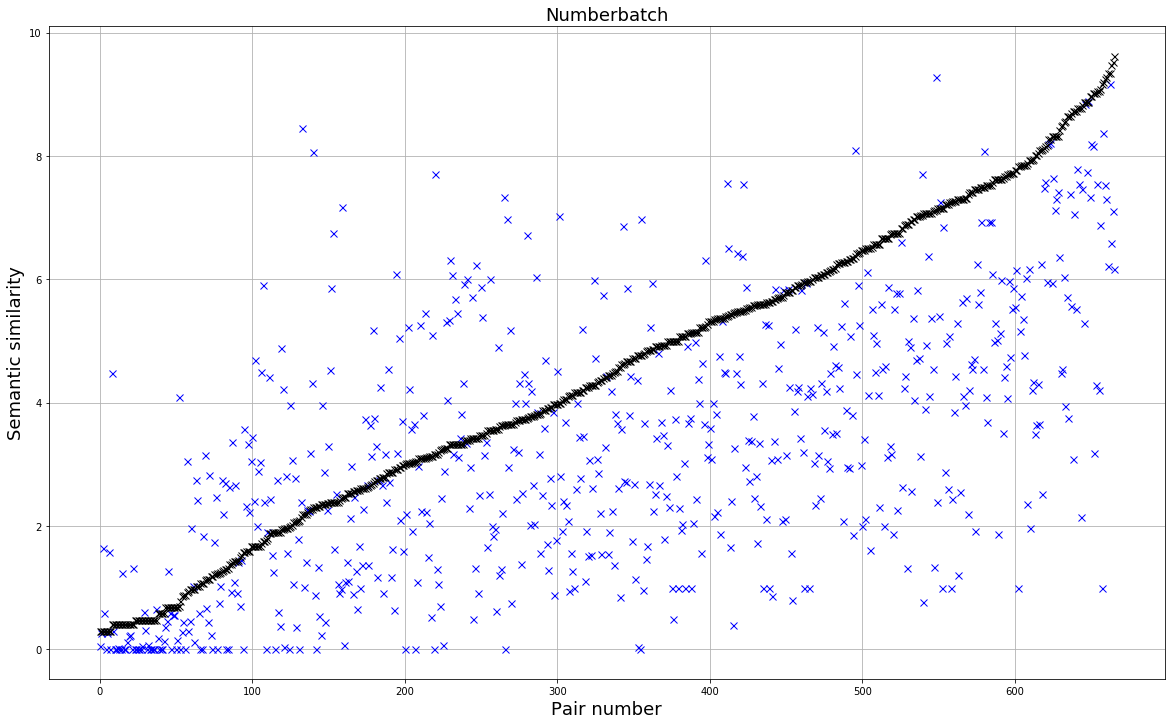

In [24]:
Numberbatch_array = []
for p in Pairs: #Pairs
    Numberbatch_array.append(numberbatch_dist(p[0], p[1]))

# Plotting
plt.rcParams["figure.figsize"] = [20,12]
f_size = 18
plt.plot(Numberbatch_array, color='b', linestyle='None', marker='x', markersize=7, linewidth=1 )  
plt.title('Numberbatch', fontsize=f_size)
plt.xlabel('Pair number', fontsize=f_size)
plt.ylabel('Semantic similarity', fontsize=f_size)
plt.grid(True)

plt.plot([x[2] for x in Pairs], color='k', linestyle='None', marker='x', markersize=7, linewidth=1 ) 
    
print "\n    Spearman correlation coefficient: ", spearmanr(Numberbatch_array, [x[2] for x in Pairs])[0]

In [44]:
Pairs

[['hole', 'agreement', 0.3],
 ['island', 'task', 0.3],
 ['chapter', 'tail', 0.3],
 ['gun', 'fur', 0.3],
 ['cliff', 'tail', 0.3],
 ['ankle', 'window', 0.3],
 ['princess', 'island', 0.3],
 ['container', 'mouse', 0.3],
 ['absence', 'presence', 0.4],
 ['belief', 'flower', 0.4],
 ['endurance', 'band', 0.4],
 ['flower', 'endurance', 0.4],
 ['cent', 'size', 0.4],
 ['liquor', 'century', 0.4],
 ['hymn', 'straw', 0.4],
 ['dentist', 'colonel', 0.4],
 ['wife', 'straw', 0.4],
 ['rice', 'boy', 0.4],
 ['dollar', 'people', 0.4],
 ['bath', 'balloon', 0.4],
 ['stomach', 'bedroom', 0.4],
 ['bicycle', 'bedroom', 0.4],
 ['log', 'bath', 0.4],
 ['chapter', 'choice', 0.48],
 ['trick', 'size', 0.48],
 ['condition', 'boy', 0.48],
 ['doctor', 'temper', 0.48],
 ['presence', 'door', 0.48],
 ['mouse', 'management', 0.48],
 ['task', 'highway', 0.48],
 ['night', 'chapter', 0.48],
 ['gun', 'trick', 0.48],
 ['bath', 'wife', 0.48],
 ['people', 'cent', 0.48],
 ['camera', 'president', 0.48],
 ['deck', 'mouse', 0.48],
 ['p